In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy import stats
import seaborn as sns

In [ ]:
df = pd.read_csv('tweets.csv')
df.dataframeName = 'tweets.csv'
df.head(100)

,author,content,country,date_time,id,language,latitude,longitude,number_of_likes,number_of_shares
0,katyperry,Is history repeating itself...?#DONTNORMALIZEH...,NaN,12/01/2017 19:52,8.196330e+17,en,NaN,NaN,7900,3472
1,katyperry,@barackobama Thank you for your incredible gra...,NaN,11/01/2017 08:38,8.191010e+17,en,NaN,NaN,3689,1380
2,katyperry,Life goals. https://t.co/XIn1qKMKQl,NaN,11/01/2017 02:52,8.190140e+17,en,NaN,NaN,10341,2387
3,katyperry,Me right now 🙏🏻 https://t.co/gW55C1wrwd,NaN,11/01/2017 02:44,8.190120e+17,en,NaN,NaN,10774,2458
4,katyperry,SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...,NaN,10/01/2017 05:22,8.186890e+17,en,NaN,NaN,17620,4655
...,...,...,...,...,...,...,...,...,...,...
95,katyperry,@KatyCute_ this edit lol,NaN,23/10/2016 06:54,7.900840e+17,en,NaN,NaN,2261,554
96,katyperry,@sella_sandra my birthdays soon💅🏼,NaN,23/10/2016 06:43,7.900810e+17,en,NaN,NaN,2429,697
97,katyperry,@KpCatt @HillaryClinton next level,NaN,23/10/2016 06:43,7.900810e+17,en,NaN,NaN,2058,510
98,katyperry,@perrysoldier Welcs ho,NaN,23/10/2016 06:37,7.900800e+17,en,NaN,NaN,1972,488


In [ ]:
def  verificar_dados():
  print(f"Tipos de dados:\n{df.dtypes}\n")
  print(f"Descrição dos dados:\n{df.describe()}\n")
  print(f"Verificar percentual de valores nulos:\n{df.isnull().mean() * 100}\n")
  print(f"Verificar percentual de valores nulos:\n{df.notnull().sum()}\n")
  print(f"Valores duplicados: {df.duplicated().sum()}\n")

  intervalos_valores = {col: (df[col].min(), df[col].max()) for col in df.select_dtypes(include=[np.number]).columns}
  print(f"Intervalos de valores:\n{intervalos_valores}\n")
  print(f"Dados do tipo numerico:\n{df.select_dtypes(include=['number']).head(100)}\n")

verificar_dados()

Tipos de dados:
author               object
content              object
country              object
date_time            object
id                  float64
language             object
latitude            float64
longitude           float64
number_of_likes       int64
number_of_shares      int64
dtype: object

Descrição dos dados:
                 id   latitude   longitude  number_of_likes  number_of_shares
count  5.254200e+04   1.000000    1.000000     52542.000000      52542.000000
mean   5.741141e+17  37.776973 -122.416523      9637.838339       5386.880857
std    2.009723e+17        NaN         NaN     18759.083482      11517.259484
min    6.789717e+09  37.776973 -122.416523         0.000000          0.000000
25%    4.485852e+17  37.776973 -122.416523       916.000000        378.000000
50%    6.337935e+17  37.776973 -122.416523      2595.500000       1266.000000
75%    7.336588e+17  37.776973 -122.416523     10300.750000       5205.000000
max    8.237200e+17  37.776973 -122.416523  

In [ ]:
# Limpeza dos dados
def limpar_dados(df):
    # Remover colunas irrelevantes
    for col in ['country', 'latitude', 'longitude', 'id']:
        if col in df.columns:
            df = df.drop(col, axis=1)
    # Transformar variáveis categóricas
    df = pd.get_dummies(df, columns=['language'], drop_first=True)
    return df

df = limpar_dados(df)

      author                                            content  \
0  katyperry  Is history repeating itself...?#DONTNORMALIZEH...   
1  katyperry  @barackobama Thank you for your incredible gra...   
2  katyperry                Life goals. https://t.co/XIn1qKMKQl   
3  katyperry            Me right now 🙏🏻 https://t.co/gW55C1wrwd   
4  katyperry  SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...   

          date_time  number_of_likes  number_of_shares  language_cs  \
0  12/01/2017 19:52             7900              3472        False   
1  11/01/2017 08:38             3689              1380        False   
2  11/01/2017 02:52            10341              2387        False   
3  11/01/2017 02:44            10774              2458        False   
4  10/01/2017 05:22            17620              4655        False   

   language_cy  language_da  language_de  language_en  ...  language_no  \
0        False        False        False         True  ...        False   
1        False      

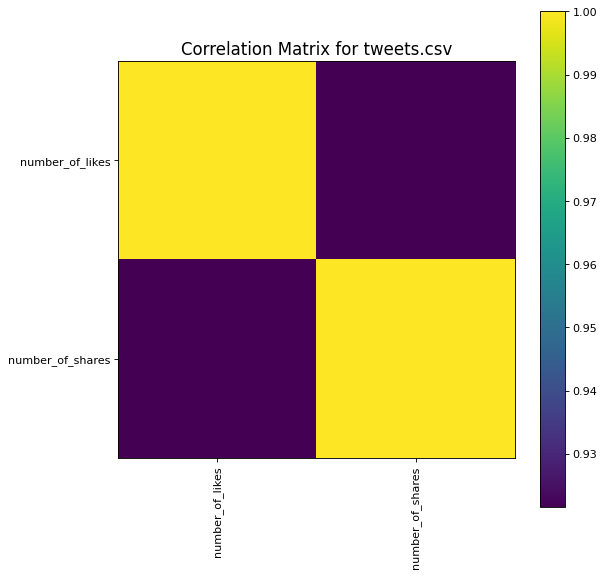

In [ ]:
# Correlation matrix
df.dataframeName = 'tweets.csv'
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName

    # Remover colunas com valores NaN
    df = df.dropna(axis=1, how='all')
    print(df.head())

    # Filtrar apenas colunas numéricas
    df = df.select_dtypes(include=['number'])

    # Remover colunas com apenas 1 valor único (constantes)
    df = df[[col for col in df if df[col].nunique() > 1]]

    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return

    # Calcular a matriz de correlação
    corr = df.corr()

    # Plotando a matriz de correlação
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


plotCorrelationMatrix(df, 8)

In [ ]:
# Identificar e Remover Outliers
def remover_outliers(df):
    z_scores = stats.zscore(df.select_dtypes(include=['number']))
    outliers = (z_scores > 3) | (z_scores < -3)
    df_cleaned = df[(~outliers).all(axis=1)]
    print(outliers.sum())
    return df_cleaned

df = remover_outliers(df)


number_of_likes     1158
number_of_shares    1339
dtype: int64


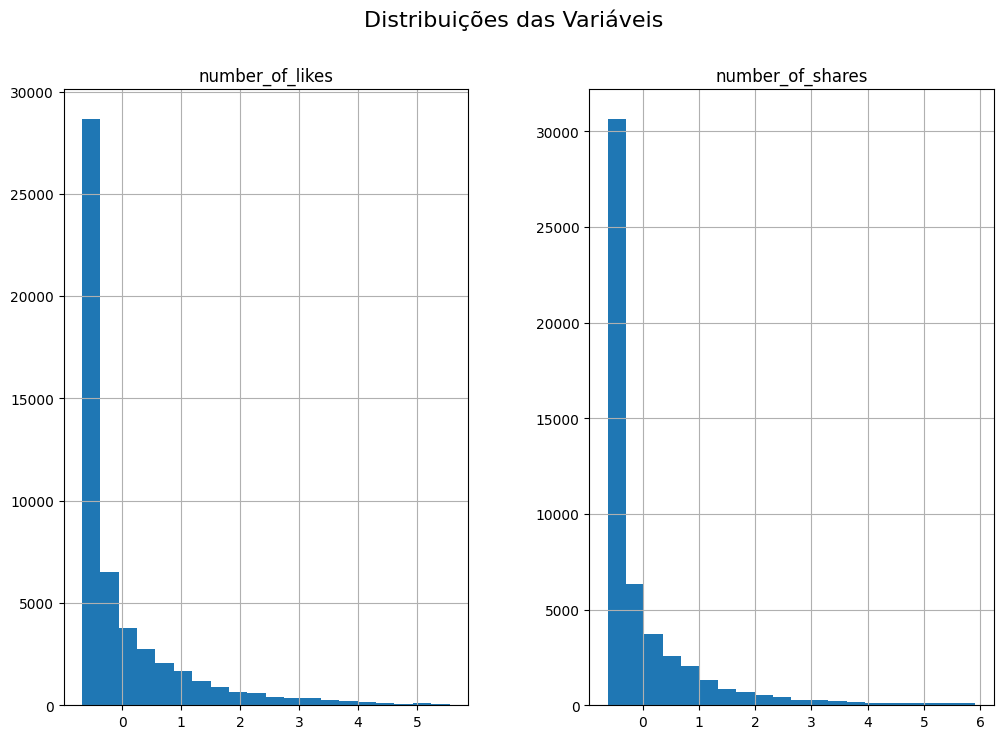

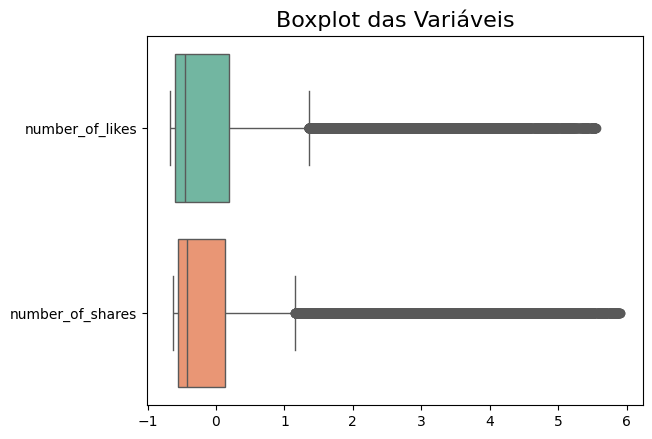

In [ ]:
# Visualizações iniciais
def visualizar_dados(df):
    df.hist(figsize=(12, 8), bins=20)
    plt.suptitle("Distribuições das Variáveis", fontsize=16)
    plt.show()

    sns.boxplot(data=df, orient="h", palette="Set2")
    plt.title("Boxplot das Variáveis", fontsize=16)
    plt.show()

visualizar_dados(df)

In [ ]:
# Normalizar dados numéricos
def normalizar_dados(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df.select_dtypes(include=['number']))
    return pd.DataFrame(df_scaled, columns=df.select_dtypes(include=['number']).columns)

df = normalizar_dados(df)
df

,number_of_likes,number_of_shares
0,0.069098,-0.053191
1,-0.329495,-0.395391
2,0.300151,-0.230670
3,0.341136,-0.219057
4,0.989146,0.140319
...,...,...
50923,2.425916,3.271319
50924,1.376190,1.425369
50925,1.713163,1.927873
50926,0.834384,1.089221


In [ ]:
# Clusterização
def determinar_numero_clusters(df, features):
    inertia = []
    k_range = range(2, 11)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df[features])
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(k_range, inertia, marker='o')
    plt.title("Método Elbow")
    plt.xlabel("Número de Clusters (k)")
    plt.ylabel("Inércia")
    plt.show()


In [ ]:
def aplicar_kmeans(df, features, k):
    kmeans = KMeans(n_clusters=k, random_state=42) #random_state=0
    df['cluster'] = kmeans.fit_predict(df[features])

    # Avaliar a qualidade da clusterização
    silhouette_avg = silhouette_score(df[features], df['cluster'])
    db_score = davies_bouldin_score(df[features], df['cluster'])
    ch_score = calinski_harabasz_score(df[features], df['cluster'])

    print(f"Coeficiente de Silhouette: {silhouette_avg:.2f}")
    print(f"Índice Davies-Bouldin: {db_score:.2f}")
    print(f"Índice Calinski-Harabasz: {ch_score:.2f}")

    return df

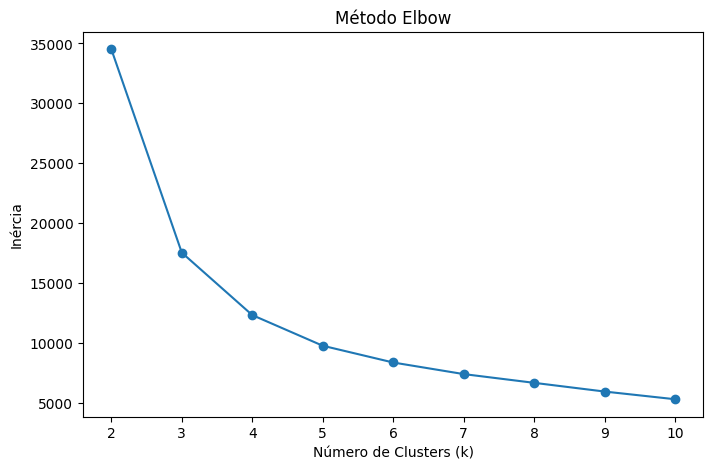

In [ ]:
features = ['number_of_likes', 'number_of_shares']
determinar_numero_clusters(df, features)

In [ ]:
k_optimal = 3  # Escolha baseada no método Elbow
df = aplicar_kmeans(df, features, k_optimal)

Coeficiente de Silhouette: 0.69
Índice Davies-Bouldin: 0.61
Índice Calinski-Harabasz: 122371.62


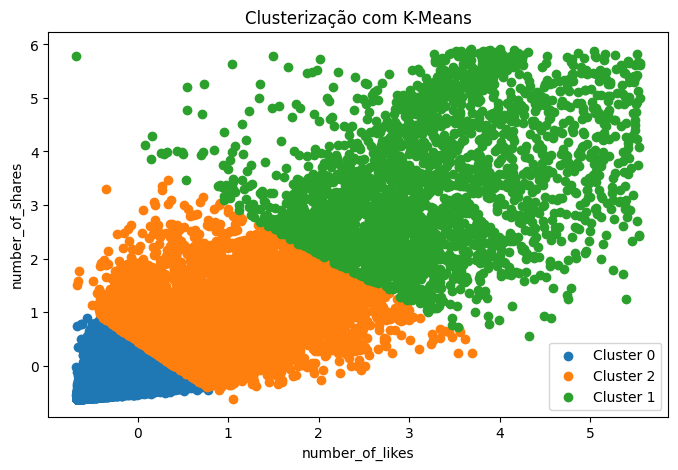

In [ ]:
# Visualizar os Clusters
def visualizar_clusters(df, features):
    plt.figure(figsize=(8, 5))
    for cluster in df['cluster'].unique():
        cluster_data = df[df['cluster'] == cluster]
        plt.scatter(cluster_data[features[0]], cluster_data[features[1]], label=f'Cluster {cluster}')

    plt.title("Clusterização com K-Means")
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend()
    plt.show()

visualizar_clusters(df, features)

In [ ]:
# Finalização
def resumo_clusters(df):
    resumo = df.groupby('cluster')[features].mean()
    print("Resumo dos Clusters:")
    print(resumo)

resumo_clusters(df)

Resumo dos Clusters:
         number_of_likes  number_of_shares
cluster                                   
0              -0.443678         -0.422167
1               3.155846          3.301812
2               0.919628          0.791013
